In [57]:
from scipy.optimize import differential_evolution
import joblib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# we use this because our model (tree) is a stepwise not a smooth cont (calculus) fxn
# grid search would be faster for two variabless but we use this for antifragility (more var)
# our opt is finding the lowest possible altitude blindfolded on a hill
# it droops paratroopers randomly and checks their altitude
# kills everyone higher and keeps only the lower
# drops next gen of paratr below or around the lowest and as such

#np.random.seed(42)

Target_UCS = 50
Target_RQD = 87
Target_chain =  2000

NB_DIR = os.getcwd()
PROJECT_ROOT = os.path.dirname(NB_DIR)
model_path = os.path.join(PROJECT_ROOT, 'models')

model = joblib.load(os.path.join(model_path, 'xgb_model.pkl')) # we dont want model to be defined every time ojb fxn is called so it out

def obj_fxn(x):

    # here x is a two element list [thrust, rpm]
    current_thrust = x[1]
    current_rpm = x[0]


    # because whichever data title was the model trained on, it should be asked in that, all input data must be there
    input_df = pd.DataFrame({ # even the order has to be same
        'Chainage_m' : [Target_chain],
        'UCS_MPa': [Target_UCS],
        'RPM' : [current_rpm],
        'RQD_pct' : [Target_RQD], # since its a dataframe we need to tell it that its a row of one object
        'Thrust_KN' : [current_thrust]

    })


    ROP_m_hr = model.predict(input_df)[0] # model.predict returns a box but we need apple within that box, we cant do
    # anything with that box, in this case its just one and its a number or else wed set up as a dataframe column
    # Physics Constraints
    if ROP_m_hr < 0.1: ROP_m_hr = 0.1

    PRICE_PER_CUTTER = 1500 # $
    WEAR_FACTOR = 0.0005  # how to calc in real data?

    Energy_price = [0.09, 0.35]  # usd per KWh, grid and diesel
    ran_price_index = np.random.randint(0,2) # upper bound is exlcusive

    Power_KW = current_thrust * current_rpm / 100

    current_price = Energy_price[ran_price_index]

    energy_cost_m = Power_KW * current_price / ROP_m_hr
    cutter_wear_index = Target_UCS**2 * current_rpm * WEAR_FACTOR

    cutter_cost_m = (cutter_wear_index * PRICE_PER_CUTTER) / ROP_m_hr
    Fixed_Cost_Hourly = 2000
    time_cost_m = Fixed_Cost_Hourly / ROP_m_hr
    total_cost = time_cost_m + cutter_cost_m + energy_cost_m
    return total_cost




bounds = [(2,12), (2000,6000) ]        # bounds for rpm and thrust
# here is a critical thing, the x we specifided is this, its order wise index
# xgb can only predict within the trained data range so we used this
# even if true optimal were outside the data we could not get it
# but its good cuz its not safe to operate outside the known limits
# but if it hits the ceiling (flaltlines to 6K) thats an indication that rather thn being max limit
# we are cutting our growth due to data limitations

In [58]:

result = differential_evolution( # here we didnt call fxn and use (), we are not calling fxn ourselves but giving
    # the optimizer the blueprint of what it should execute, x is given by bounds, thats its blakc box
    obj_fxn, # what we need to optimize
    bounds,
    strategy='best1bin', #"Take the Best Guy's position, add a little bit of randomness based on how far apart the other guys are, and spawn a new guy there."
    # bin = binomial crossover, we could use rand1bin, for eng control best1bin is fine
    maxiter=20, # generations of trooper landing on hills
    popsize=10, # no of paratr in a gen
    tol=0.01, # stop when improvement < 1%# its a randomized guess, we want it to guess in the same order for now but seed=42 is for 1.9 higher versions
)

--- OPTIMAL STRATEGY ---
Set RPM to:     2.01
Set Thrust to:  5139 kN
Min Cost:       $897.16 / m


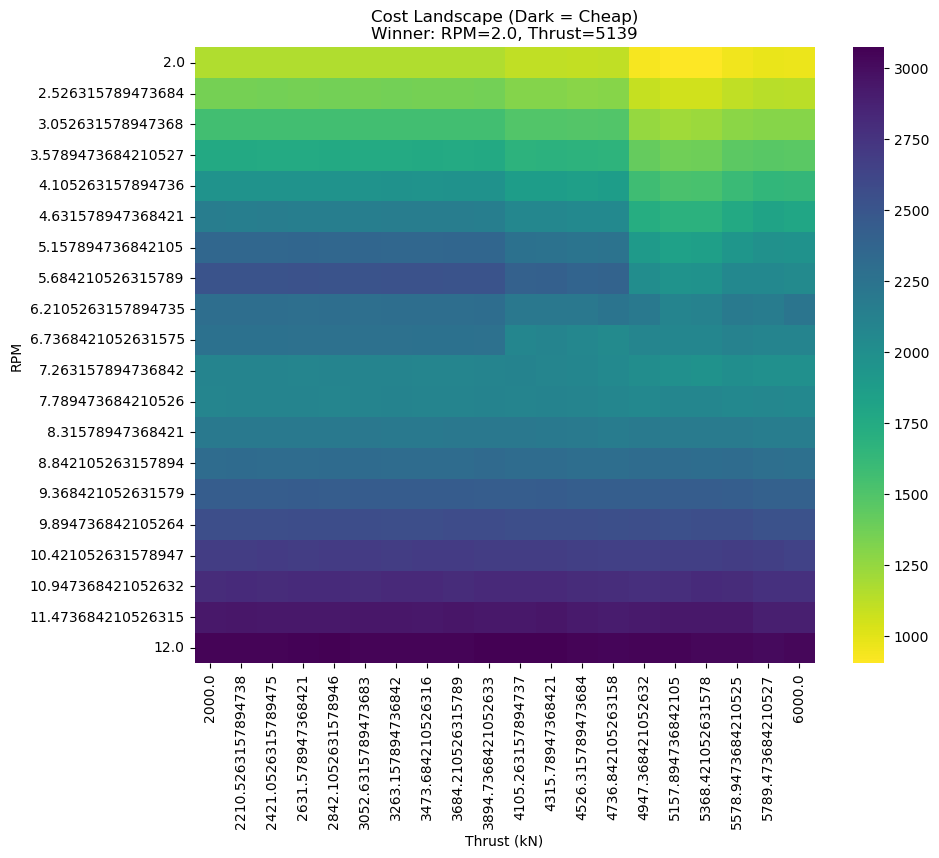

In [59]:
best_rpm = result.x[0]
best_thrust = result.x[1]
min_cost = result.fun

print(f"--- OPTIMAL STRATEGY ---")
print(f"Set RPM to:     {best_rpm:.2f}")
print(f"Set Thrust to:  {best_thrust:.0f} kN")
print(f"Min Cost:       ${min_cost:.2f} / m")

# --- 5. THE VISUALIZATION (The Map) ---
# Since Scipy doesn't give us the map, we quickly generate a coarse grid
# just to SHOW you what the "Valley" looks like.

# Create a 20x20 grid
rpm_grid = np.linspace(2, 12, 20)
thrust_grid = np.linspace(2000, 6000, 20)
heatmap_data = []

for r in rpm_grid:
    for t in thrust_grid:
        # Reuse our function!
        c = obj_fxn([r, t])
        heatmap_data.append({'RPM': r, 'Thrust': t, 'Cost': c})

# Plot
df_viz = pd.DataFrame(heatmap_data)
pivot = df_viz.pivot(index='RPM', columns='Thrust', values='Cost')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot, cmap='viridis_r', annot=False)
# 'viridis_r' reversed means Dark Blue = Low Cost (The Valley)
# Bright Yellow = High Cost (The Peaks)

# Mark the winner
plt.title(f"Cost Landscape (Dark = Cheap)\nWinner: RPM={best_rpm:.1f}, Thrust={best_thrust:.0f}")
plt.xlabel("Thrust (kN)")
plt.ylabel("RPM")
plt.show()